### Direct estimates of lateral heat flux for all profiles

Polynomial fitting to density, described in Fernandez-Castro et al. (2025), to remove density compensated medium scale intrusions and obtain a 'mean' profile.

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as scipy
import cmocean
import math
import gsw
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

plt.rcParams['font.size'] = '12'

In [2]:
workingdir = r'C:\Users\mijakes\checkouts\phd-public'
os.chdir(workingdir) 

import imp
import src.importData as imports
import src.calc as calc
import src.grid_data as grid_data
import src.interpolation as interp
import src.plots as plots
import src.stats as stats
import src.concat as ct
import src.velocities as vel
import src.settings as settings

In [3]:
# Path to save figures
my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter2_manuscript')

In [4]:
fltdir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')
floatids = [8489, 8492, 8493]
ema = imports.importFloatData(floatids)

In [5]:
# Import satellite altimetry data 
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')
alt_cmems = imports.importNetCDF(datadir, 'CMEMS.nc', datatype ='altimetry')

In [6]:
rot_vels = {}
for floatid in floatids:
    #rotated velocities
    file = os.path.join(fltdir, 'rotated_velocity', 'by_profile', 'rot_vel_%s.nc' %floatid)
    rot_vels[floatid] = xr.open_dataset(file)

# half-inertial pair averaged float dataset
imp.reload(imports)
ds = imports.sub_inertial_ds(ema, floatids, fltdir, xdim = 'distance', rot_vels = rot_vels)

In [7]:
floatids = [8489, 8492, 8493]

CT, SA, P = {}, {}, {}
mld_on_d = {}
mld = {}
dens = {}

for floatid in floatids:
    pressure = np.tile(ds[floatid].pressure, (len(ds[floatid].CT), 1))
    ds[floatid]['P'] = xr.DataArray(pressure, dims = ds[floatid].CT.dims, coords = ds[floatid].CT['pressure'].coords)

    CT[floatid], SA[floatid], P[floatid] = ds[floatid].CT, ds[floatid].SA, ds[floatid].P
    dens[floatid] = calc.potentialDensity(P[floatid], SA[floatid], CT[floatid])
    mld_on_d[floatid] = calc.MLD_on_dens(dens[floatid], criteria = 0.03, pref = 10)
    mld[floatid] = calc.MLD(dens[floatid], criteria = 0.03, pref = 10)

In [8]:
hf_ds = {}
for floatid in floatids:
    hf_ds[floatid] = calc.direct_lateral_heat_flux(CT[floatid], dens[floatid], ds[floatid].v_rot, 
                                                       mld[floatid], order = 4, window = 125)

In [65]:
# depth-integrated estimates in the upper 1000m
hf_1000 = hf_ds[8489].heat_flux.sel(pressure = slice(0,1000))

## replace nans with zero 
hf_nonan = hf_1000.where(~np.isnan(hf_1000), 0)

# integrated_hf = np.trapz(hf_nonan, axis = 1)
integrated_hf = np.trapz(abs(hf_nonan), axis = 1)
integrated_hf = xr.DataArray(integrated_hf, dims = ['distance'], coords = dict(distance = ('distance', hf_nonan.distance.data)))

<xarray.DataArray ()>
array(0.8435925)


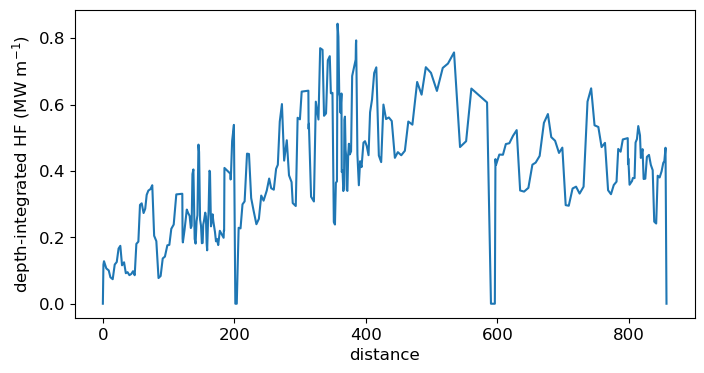

In [66]:
fig, ax = plt.subplots(figsize = (8,4))
(integrated_hf/1000).plot()
plt.ylabel('depth-integrated HF (MW m$^{-1}$)')

print(abs(integrated_hf/1000).max())

In [68]:
# across the three floats -- these are the maximum depth-intergrated lateral heat flux magnitudes (in MW/m) in the upper 1000 m,
# associated with interleaving scales.

(0.84 + 2.25 + 0.61)/3

1.2333333333333332

In [9]:
S_concat = ct.joinFloats(SA, 'distance', new_dim = False)
T_concat = ct.joinFloats(CT, 'distance', new_dim = False)
pdens_ct = ct.joinFloats(dens, 'distance', new_dim = False)

Tdens_ds, end_dist, d_rs = ct.concatenated_flts(CT, floatids, interp_to_dens = True, pdens = pdens_ct, new_dim = False, rs = False)
Sdens_ds, end_dist, d_rs = ct.concatenated_flts(SA, floatids, interp_to_dens = True, pdens = pdens_ct, new_dim = False, rs = False)

ticks, values, flt_dist_loc = plots.concatTickValues(d_rs)
flt_ind = np.where(Tdens_ds.distance == 0)[0].tolist()
flt_ind.append(len(Tdens_ds))

In [9]:
DSC = {}
DSC_smooth = {}
S_dens, T_dens = {}, {}
p_on_dens = {}

i = 0 
for floatid in floatids:
    
    S = Sdens_ds[flt_ind[i]:flt_ind[i+1]]
    T = Tdens_ds[flt_ind[i]:flt_ind[i+1]]
    density = pdens_ct[flt_ind[i]:flt_ind[i+1]]
    S_dens[floatid], T_dens[floatid] = S, T

    DSC[floatid], DSC_smooth[floatid] = calc.DSC(T, S, pdens = density, dens_interval = 0.01)
    
    p_on_dens[floatid] = interp.to_pdens_grid(P[floatid], density, zdim = 'pressure', dens_interval = 0.01)
    
    i += 1

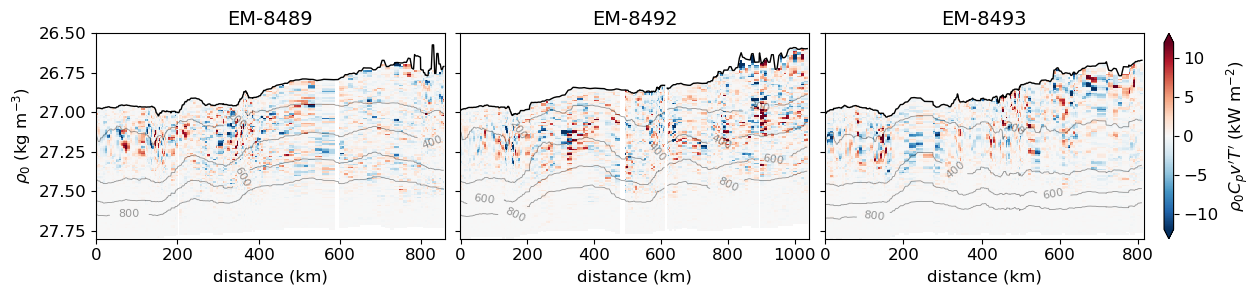

In [10]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3.1))
axs = ax.flatten()

imp.reload(interp)
i = 0
for floatid in floatids:
    heat_flux_on_d = interp.to_pdens_grid(hf_ds[floatid].heat_flux, dens[floatid], dens_interval = 0.01)
#     heat_flux_even = interp.even_dist_grid(heat_flux_on_d, 3)
#     p_on_d_even = interp.even_dist_grid(p_on_dens[floatid], 3)
#     mld_even = interp.even_dist_grid(mld_on_d[floatid], 3)
    
    im = heat_flux_on_d.plot(ax = axs[i], x = 'distance', vmin = -12, vmax = 12, cmap = 'RdBu_r', add_colorbar = False)
    
    mld_on_d[floatid].plot(ax = axs[i], c = 'k', linewidth = 1)
    
    CS = p_on_dens[floatid].plot.contour(ax = axs[i],
                                        x = 'distance', 
                                        levels = np.arange(0, 1000, 200),
                                        linewidths = 0.6, 
                                        colors = 'k', 
                                        alpha = 0.4)
    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.0f')
    
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(26.5, 27.8)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel(r'$\rho_{0}$ (kg m$^{-3}$)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = r'$\rho_{0}C_{p}v^{\prime}T^{\prime}$ (kW m$^{-2}$)', extend = 'both')

# settings.save_figure(fig, my_path, 'heat_flux_floats.png', dpi = 600, pad = 0.2)

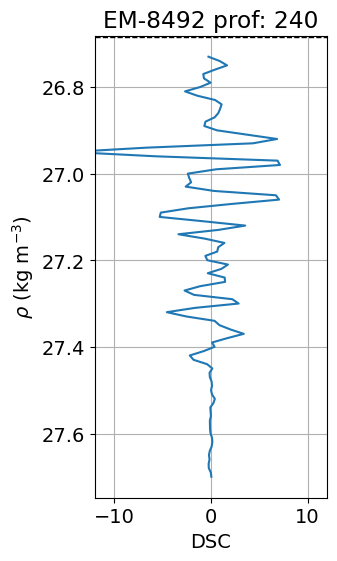

In [339]:
floatid = 8492
prof = 239

fig, ax = plt.subplots(figsize = (3, 6))
DSC_smooth[floatid][prof].plot(y = 'potential_density')
plt.axhline(y = mld_on_d[floatid][prof], c = 'k', linewidth = 1, linestyle = '--')
ax.invert_yaxis()
plt.xlim(-12, 12)
plt.title(f'EM-{floatid} prof: {prof+1}')
plt.xlabel('DSC')
plt.ylabel(r'$\rho$ (kg m$^{-3}$)')
plt.grid()

Text(0.5, 0.95, 'EM-8492, profile: 240, distance: 880 km')

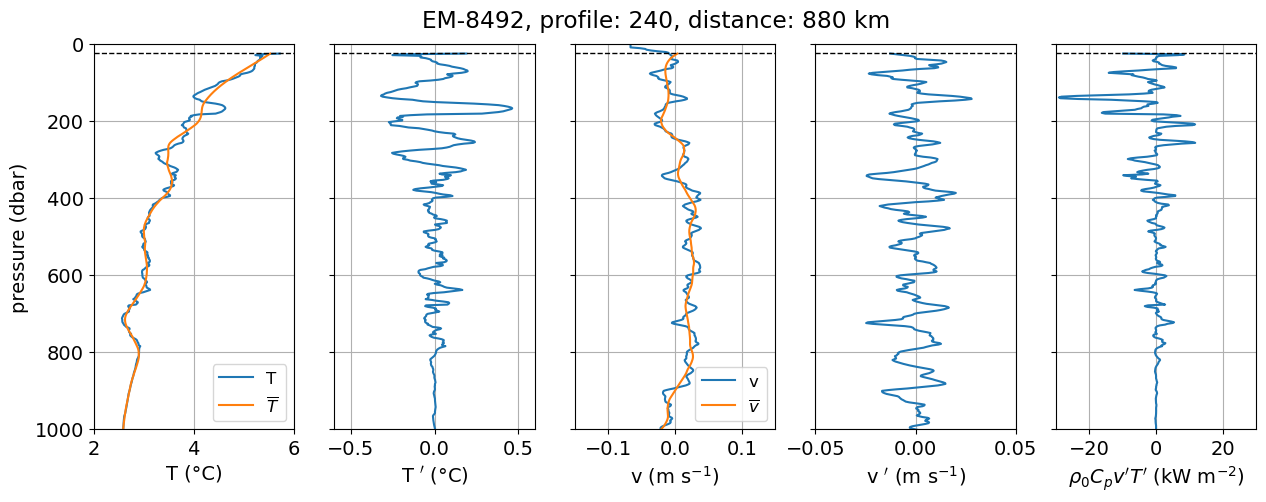

In [340]:
fig, axs = plt.subplots(1, 5, sharey = True, figsize = (15, 5))
ax = axs.flatten()

CT[floatid][prof].plot(ax = ax[0], y = 'pressure')
hf_ds[floatid].T_mean[prof].plot(ax = ax[0], y = 'pressure')
ax[0].set_ylim(0, 1000)
ax[0].invert_yaxis()
ax[0].set_xlim(2, 6)
ax[0].set_xlabel(u'T (\N{DEGREE SIGN}C)')
ax[0].legend(['T', '$\overline{T}$'], fontsize = 12)

hf_ds[floatid].T_anom[prof].plot(ax = ax[1], y = 'pressure')
ax[1].set_xlabel(u'T $^\prime$ (\N{DEGREE SIGN}C)')
ax[1].set_xlim(-0.6, 0.6)


ds[floatid].v_rot[prof].plot(ax = ax[2], y = 'pressure')
hf_ds[floatid].v_mean[prof].plot(ax = ax[2], y = 'pressure')
ax[2].set_xlim(-0.15, 0.15)
ax[2].set_xlabel('v (m s$^{-1}$)')
ax[2].legend(['v', '$\overline{v}$'], fontsize = 12, loc = 'lower right')

hf_ds[floatid].v_anom[prof].plot(ax = ax[3], y = 'pressure')
ax[3].set_xlabel('v $^\prime$ (m s$^{-1}$)')
ax[3].set_xlim(-0.05, 0.05)


hf_ds[floatid].heat_flux[prof].plot(ax = ax[4], y = 'pressure')
ax[4].set_xlim(-30, 30)
ax[4].set_xlabel(r'$\rho_{0}C_{p}v^{\prime}T^{\prime}$ (kW m$^{-2}$)')

for i in range(len(ax)):
    ax[i].grid()
    ax[i].set_ylabel('')
    ax[i].set_title('')
    ax[i].axhline(y = mld[floatid][prof], c = 'k', linewidth = 1, linestyle = '--')
    
ax[0].set_ylabel('pressure (dbar)')
# ax[4].set_title(f'mean: {avg_heat_flux[prof].data:.2f}', fontsize = 12)

fig.suptitle(f'EM-{floatid}, profile: {prof+1}, distance: {CT[floatid][prof].distance.data:0.0f} km', y=0.95)

In [ ]:
# settings.save_figure(fig, my_path, 'heat_flux_EM8492_prof240.png', dpi = 600, pad = 0.2)

In [358]:
median = False

abs_avg_dsc = {}
avg_abs_hf = {}
avg_hf = {}

for floatid in floatids:
    # mean below the ML to 1000 dbar
    dsc_on_p = interp.dens_to_pres(DSC_smooth[floatid], ds[floatid].pressure.data, P_on_d = p_on_dens[floatid])
    abs_avg_dsc[floatid] = calc.mean_below_ml(abs(dsc_on_p), mld[floatid], zmax = 1000, zdim = 'pressure', median = median)
    avg_abs_hf[floatid] = calc.mean_below_ml(abs(hf_ds[floatid].heat_flux), mld[floatid], zmax = 1000, zdim = 'pressure', median = median)
    avg_hf[floatid] = calc.mean_below_ml(hf_ds[floatid].heat_flux, mld[floatid], zmax = 1000, zdim = 'pressure', median = median)
    
    
#     # mean below the mixed layer to 27.5 kg/m3
#     dens_min = mld_on_d[floatid]
#     dens_max = np.tile(27.5, len(dens_min))
    
#     abs_avg_dsc[floatid] = calc.mean_below_ml(abs(DSC_smooth[floatid]), dens_min, zmax = 27.5, median = median)
#     avg_abs_hf[floatid] = calc.average_in_density_on_pgrid(abs(hf_ds[floatid].heat_flux), dens[floatid].data, dens_min.data, dens_max, median = median)

In [1]:
dsc_ct = np.hstack(abs_avg_dsc.values())
abs_hf_ct = np.hstack(avg_abs_hf.values())
hf_ct = np.hstack(avg_hf.values())

In [729]:
hf_label = r'$\overline{|\rho_{0}C_{p}v^{\prime}T^{\prime}|}$ (kW m$^{-2}$)'

In [730]:
avg_abs_hf[8492][prof]

2.1030937714397475

In [731]:
print(f'min avg heat flux: {np.nanmin(abs_hf_ct):.2f}')
print(f'max avg heat flux: {np.nanmax(abs_hf_ct):.2f}')
print(f'mean avg heat flux: {np.nanmean(abs_hf_ct):.2f}')

min avg heat flux: 0.14
max avg heat flux: 4.64
mean avg heat flux: 0.76


Pearsons corr: 0.713, p-value: 2.71e-122


Text(0.71, 0.04, '$y = 0.69x + 0.34$')

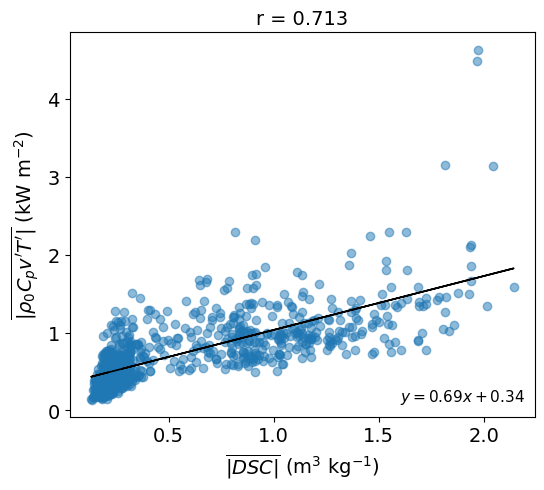

In [732]:
x, y = dsc_ct, abs_hf_ct

fig, ax = plt.subplots(figsize = (6,5))
plt.scatter(x, y, alpha = 0.5)
plt.xlabel('$\overline{|DSC|}$ (m$^{3}$ kg$^{-1}$)')
plt.ylabel(hf_label)

corr, pval =  stats.pearsons(x, y)
ax.text(0.4, 1.02, f'r = {corr:.3}', transform = ax.transAxes)

#linear fit
nonans = np.where(~np.isnan(x*y))[0]
m, b = np.polyfit(x[nonans], y[nonans], 1)
yfit = [(m * xi) + b for xi in x[nonans]]
ax.plot(x[nonans], yfit, c = 'k', linewidth = 1.2)
line = f'$y = {m:.2f}x + {b:.2f}$'
ax.text(0.71, 0.04, line, transform = ax.transAxes, fontsize = 11)

In [733]:
# settings.save_figure(fig, my_path, 'DSC_vs_HF.png', dpi = 600, pad = 0.2)

Pearsons corr: 0.042, p-value: 0.246


Text(0.71, 0.04, '$y = 0.03x + -0.01$')

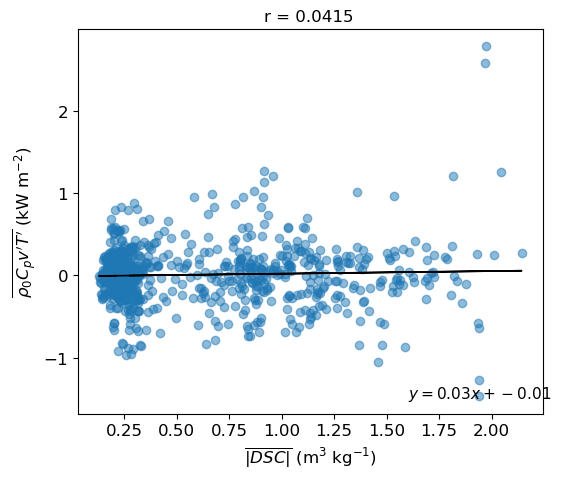

In [742]:
x, y = dsc_ct, hf_ct

fig, ax = plt.subplots(figsize = (6,5))
plt.scatter(x, y, alpha = 0.5)
plt.xlabel('$\overline{|DSC|}$ (m$^{3}$ kg$^{-1}$)')
plt.ylabel(r'$\overline{\rho_{0}C_{p}v^{\prime}T^{\prime}}$ (kW m$^{-2}$)')

corr, pval =  stats.pearsons(x, y)
ax.text(0.4, 1.02, f'r = {corr:.3}', transform = ax.transAxes)

#linear fit
nonans = np.where(~np.isnan(x*y))[0]
m, b = np.polyfit(x[nonans], y[nonans], 1)
yfit = [(m * xi) + b for xi in x[nonans]]
ax.plot(x[nonans], yfit, c = 'k', linewidth = 1.2)
line = f'$y = {m:.2f}x + {b:.2f}$'
ax.text(0.71, 0.04, line, transform = ax.transAxes, fontsize = 11)

### Apply empirical relationship to circumpolar DSC

In [280]:
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')

In [236]:
# mean dynamic topography 
filename = 'dataset-mdt-hybrid-cnes-cls22-cmems2020-global_1710994188205.nc'
file = os.path.join(os.sep, datadir, 'altimetry', filename)

MDT = xr.open_dataset(file)

In [237]:
# bathymetry
file1 = os.path.join(os.sep, datadir, 'bathy', 'gebco_2023_n-35.0_s-90.0_w0.0_e180.0.nc')
file2 = os.path.join(os.sep, datadir, 'bathy', 'gebco_2023_n-35.0_s-90.0_w-180.0_e0.0.nc')

bathymetry1 = xr.open_dataset(file1)
bathymetry2 = xr.open_dataset(file2)
bathymetry = xr.concat([bathymetry2, bathymetry1], dim = 'lon')

bathymetry['depth'] = bathymetry.elevation*-1
new_bathy = bathymetry.coarsen(lon=10).mean().coarsen(lat=10).mean()

In [571]:
# file = os.path.join(os.sep, datadir, 'mean_dsc_circumpolar.nc')
file = os.path.join(os.sep, datadir, 'mean_dsc_circumpolar_MLD-1000dbar_2005-2020.nc')
mean_dsc = xr.open_dataset(file).__xarray_dataarray_variable__

In [572]:
gradient = m
intercept = b

In [573]:
hf_circumpolar = (mean_dsc*gradient)+intercept

In [574]:
hf_grid, n_obs_grid = grid_data.bin_data(hf_circumpolar)

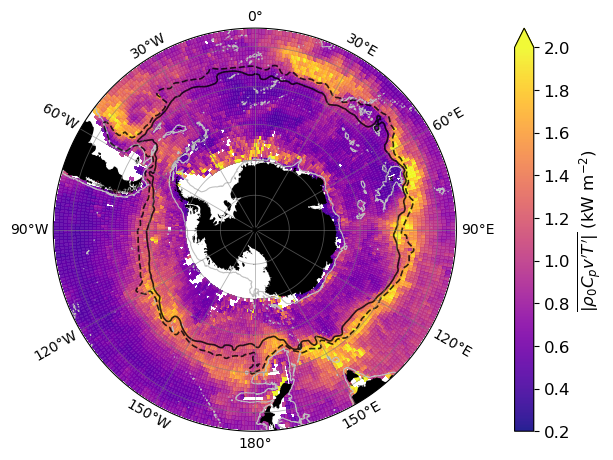

In [738]:
fig, ax = grid_data.plot_circumpolar(hf_grid, new_bathy, MDT, vmin = 0.2, vmax = 2, alpha = 0.9,
                 cmap = 'plasma', cbar_label = hf_label, mask = False)

In [739]:
# settings.save_figure(fig, my_path, 'cirucmpolar_hf_below_ML.png', dpi = 600, pad = 0.2)

In [577]:
dsc_grid, n_obs_grid = grid_data.bin_data(mean_dsc)

In [578]:
def lon_0_to_360(data):
    neg_lon = np.where(data['lon'].data < 0)[0]
    data.lon.data[neg_lon] += 360
    return data.sortby('lon')

In [707]:
dsc_PFZ = grid_data.mask_PFZ(dsc_grid, MDT, pad = 0.1)
mean_dsc_PFZ = dsc_PFZ.mean(dim = 'lat').sel(lon = slice(-180,180))
mean_dsc_PFZ = lon_0_to_360(mean_dsc_PFZ)

In [708]:
d = dsc_PFZ.where(~np.isnan(dsc_PFZ), 0)
integrated_dsc = np.trapz(d, axis = 0)
integrated_dsc = xr.DataArray(integrated_dsc, dims = ['lon'], coords = dict(lon = ('lon', dsc_PFZ.lon.data)))
integrated_dsc = lon_0_to_360(integrated_dsc)

Text(0.5, 1.0, 'Integrated across the PFZ')

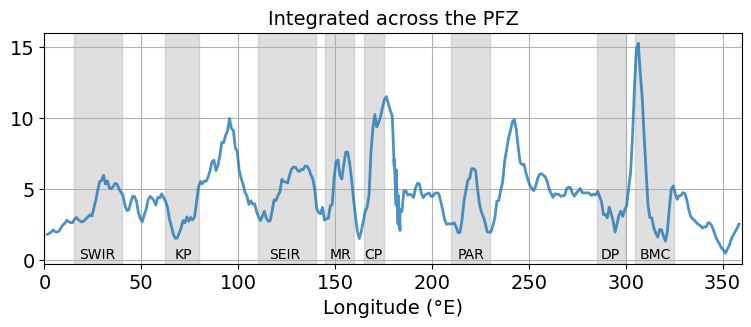

In [709]:
fig, ax = plt.subplots(figsize = (9,3))
integrated_dsc.rolling(lon = 3, center = True).mean().plot(c='tab:blue', linewidth = 2, alpha = 0.8)

ax.axvspan(xmin = 15, xmax = 40, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 62, xmax = 80, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 110, xmax = 140, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 145, xmax = 160, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 165, xmax = 175, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 210, xmax = 230, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 285, xmax = 300, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 305, xmax = 325, color = 'grey', alpha = 0.25)

ax.text(18, 0.07, 'SWIR', fontsize = 10)
ax.text(67, 0.07, 'KP', fontsize = 10)
ax.text(116, 0.07, 'SEIR', fontsize = 10)
ax.text(147, 0.07, 'MR', fontsize = 10)
ax.text(165, 0.07, 'CP', fontsize = 10)
ax.text(213, 0.07, 'PAR', fontsize = 10)
ax.text(287, 0.07, 'DP', fontsize = 10)
ax.text(307, 0.07, 'BMC', fontsize = 10)

plt.grid()
plt.xlim(0, 360)
# plt.ylim(0, 2.5)
plt.xlabel('Longitude (\N{DEGREE SIGN}E)')
plt.title(r'Integrated across the PFZ', fontsize = 14)

In [710]:
nonans = []
mean_lat = []
for n in range(len(dsc_PFZ.lon)):
    nonan = np.where(~np.isnan(dsc_PFZ[:,n]))[0]
    mean_lat.append(dsc_PFZ[nonan, n].lat.mean().data)
    nonans.append(len(nonan))

In [711]:
### mean in latitude space, +/- 1 degree lat from mean position of PFZ 
mean_dsc_avgPFZ = []
for n in range(len(dsc_PFZ.lon)):
    mean_dsc_avgPFZ.append(dsc_grid[n].sel(lat = slice(mean_lat[n]-1, mean_lat[n]+1)).mean(skipna = True).data)
    
mean_dsc_avgPFZ = xr.DataArray(np.asarray(mean_dsc_avgPFZ), dims = ['lon'], coords = dict(lon = ('lon', dsc_PFZ.lon.data)))
mean_dsc_avgPFZ = lon_0_to_360(mean_dsc_avgPFZ)

Text(0.5, 1.0, 'Average across the PFZ')

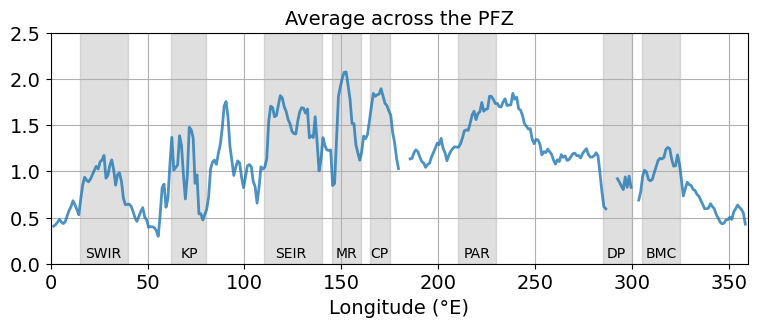

In [712]:
fig, ax = plt.subplots(figsize = (9,3))
mean_dsc_avgPFZ.rolling(lon = 3, center = True).mean().plot(c='tab:blue', linewidth = 2, alpha = 0.8)

ax.axvspan(xmin = 15, xmax = 40, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 62, xmax = 80, color = 'grey', alpha = 0.25)
# ax.axvspan(xmin = 81, xmax = 96, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 110, xmax = 140, color = 'grey', alpha = 0.25)
# ax.axvspan(xmin = 135, xmax = 180, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 145, xmax = 160, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 165, xmax = 175, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 210, xmax = 230, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 285, xmax = 300, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 305, xmax = 325, color = 'grey', alpha = 0.25)

ax.text(18, 0.07, 'SWIR', fontsize = 10)
ax.text(67, 0.07, 'KP', fontsize = 10)
ax.text(116, 0.07, 'SEIR', fontsize = 10)
ax.text(147, 0.07, 'MR', fontsize = 10)
ax.text(165, 0.07, 'CP', fontsize = 10)
ax.text(213, 0.07, 'PAR', fontsize = 10)
ax.text(287, 0.07, 'DP', fontsize = 10)
ax.text(307, 0.07, 'BMC', fontsize = 10)

plt.grid()
plt.xlim(0, 360)
plt.ylim(0, 2.5)
plt.xlabel('Longitude (\N{DEGREE SIGN}E)')
plt.title(r'Average across the PFZ', fontsize = 14)

In [713]:
hf_PFZ = grid_data.mask_PFZ(hf_grid, MDT, pad = 0.1)
mean_hf_PFZ = hf_PFZ.mean(dim = 'lat').sel(lon = slice(-180,180))
mean_hf_PFZ = lon_0_to_360(mean_hf_PFZ)

Text(0.5, 1.0, 'Average across the PFZ')

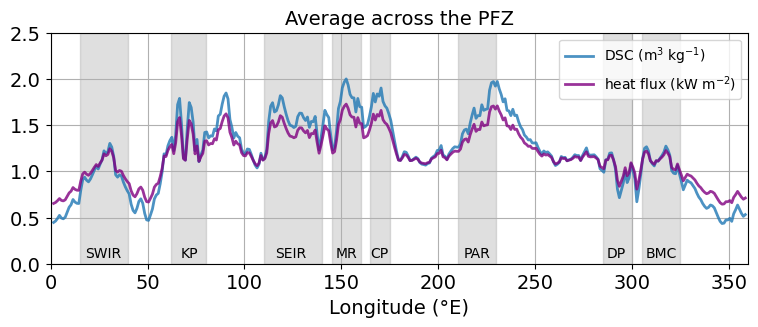

In [727]:
fig, ax = plt.subplots(figsize = (9,3))
mean_dsc_PFZ.rolling(lon = 3, center = True).mean().plot(c='tab:blue', linewidth = 2, alpha = 0.8)
mean_hf_PFZ.rolling(lon = 3, center = True).mean().plot(c='purple', linewidth = 2, alpha = 0.8)
plt.legend(['DSC (m$^{3}$ kg$^{-1}$)',  'heat flux (kW m$^{-2}$)'], fontsize = 10, loc = 'upper right')
ax.axvspan(xmin = 15, xmax = 40, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 62, xmax = 80, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 110, xmax = 140, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 145, xmax = 160, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 165, xmax = 175, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 210, xmax = 230, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 285, xmax = 300, color = 'grey', alpha = 0.25)
ax.axvspan(xmin = 305, xmax = 325, color = 'grey', alpha = 0.25)

ax.text(18, 0.07, 'SWIR', fontsize = 10)
ax.text(67, 0.07, 'KP', fontsize = 10)
ax.text(116, 0.07, 'SEIR', fontsize = 10)
ax.text(147, 0.07, 'MR', fontsize = 10)
ax.text(165, 0.07, 'CP', fontsize = 10)
ax.text(213, 0.07, 'PAR', fontsize = 10)
ax.text(287, 0.07, 'DP', fontsize = 10)
ax.text(307, 0.07, 'BMC', fontsize = 10)

plt.grid()
plt.xlim(0, 360)
plt.ylim(0, 2.5)
plt.xlabel('Longitude (\N{DEGREE SIGN}E)')
plt.title(r'Average across the PFZ', fontsize = 14)

In [728]:
# settings.save_figure(fig, my_path, 'avg_HF_DSC_PFZ_2005-2020.png', dpi = 600, pad = 0.2)

In [11]:
dsc_integral = {}
abs_hf_integral = {}
hf_integral = {}

for floatid in floatids:
    # mean below the mixed layer to 27.5 kg/m3
    dens_min = mld_on_d[floatid]
    dens_max = np.tile(27.5, len(dens_min))
    
    hf_integral[floatid] = calc.average_in_density_on_pgrid(hf_ds[floatid].heat_flux, dens[floatid].data, dens_min.data, dens_max, integrate = True)
    abs_hf_integral[floatid] = calc.average_in_density_on_pgrid(abs(hf_ds[floatid].heat_flux), dens[floatid].data, dens_min.data, dens_max, integrate = True)
    dsc_integral[floatid] = calc.mean_below_ml(abs(DSC_smooth[floatid]), dens_min, zmax = 27.5, integrate = True)

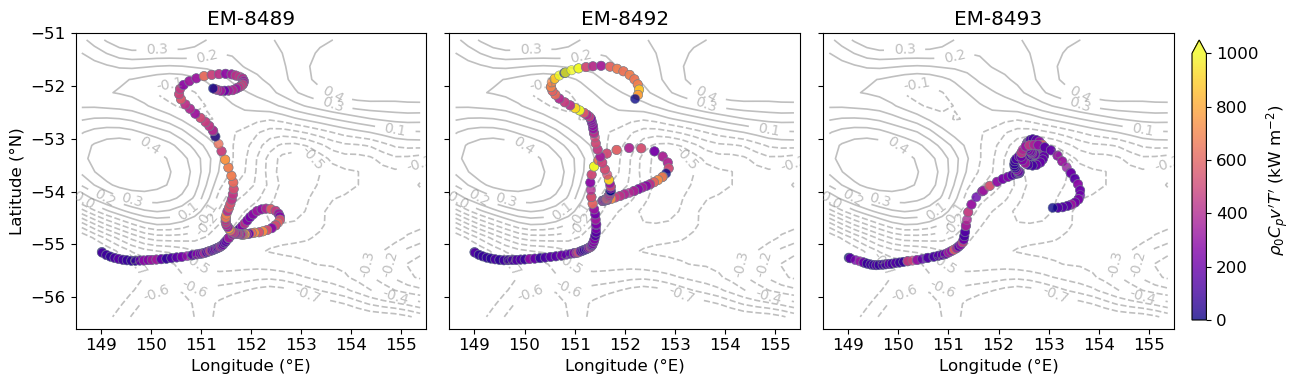

In [34]:
## Float trajectories coloured by depth-avg heat flux magnitude
imp.reload(plots)

data_dict = avg_abs_hf
label = r'$\rho_{0}C_{p}v^{\prime}T^{\prime}$ (kW m$^{-2}$)'
vmin, vmax =  0, 2.5
cmap = 'plasma' 
ssh = np.arange(-0.7, 0.5, 0.1)


fig, axs = plt.subplots(1, 3, sharey = True, figsize = (12,4))
axs = axs.flatten()
                                                                    
floatids = [8489, 8492, 8493]
i = 0
for floatid in floatids: 
    float_num = ema[floatid]

    im, msl = plots.colTrajectory(axs[i], data_dict[floatid], float_num, floatid, alt_cmems, 
                                  msl_contours = False, cmap = cmap, vmin = vmin, vmax = vmax, s = 45,
                                  alpha = 0.8, edgecolors='slategrey', linewidth = 0.4)
    
    
    CS = msl.plot.contour(ax = axs[i], colors = 'gray', linewidths = 1.2, alpha = 0.5, levels = ssh, zorder = 1)
    axs[i].clabel(CS, inline=True, fontsize=10, fmt = '%1.1f')
    axs[i].set_xlabel('Longitude (°E)')
    axs[i].set_ylabel('')
    axs[i].set_title(f'EM-{floatid}')
    
    i+=1
    
axs[0].set_ylabel('Latitude (°N)')
plt.tight_layout()

cbar_ax = fig.add_axes([1, 0.18, 0.012, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, extend = 'max', label = label)

In [229]:
# dsc_ct = np.hstack(dsc_integral.values())
hf_ct = ct.joinFloats(hf_integral, 'distance', new_dim = False)
abs_hf_ct = ct.joinFloats(abs_hf_integral, 'distance', new_dim = False)

Pearsons corr: 0.698, p-value: 8.06e-117


Text(0.04, 0.94, '$y = 294.7x 109.5$')

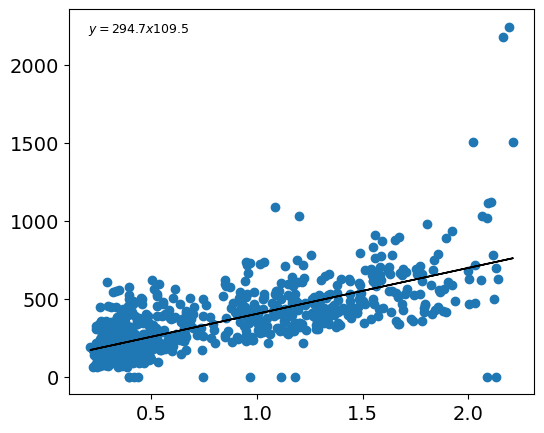

In [230]:
fig, ax = plt.subplots(figsize = (6,5))
plt.scatter(dsc_ct, abs_hf_ct)
corr, pval =  stats.pearsons(dsc_ct, abs_hf_ct)

#linear fit
x, y = dsc_ct, abs_hf_ct
nonans = np.where(~np.isnan(x*y))[0]
m, b = np.polyfit(x[nonans], y[nonans], 1)
yfit = [(m * xi) + b for xi in x[nonans]]
ax.plot(x[nonans], yfit, c = 'k', linewidth = 1.2)
line = f'$y = {m:.1f}x {b:.1f}$'
ax.text(0.04, 0.94, line, transform = ax.transAxes, fontsize = 9)

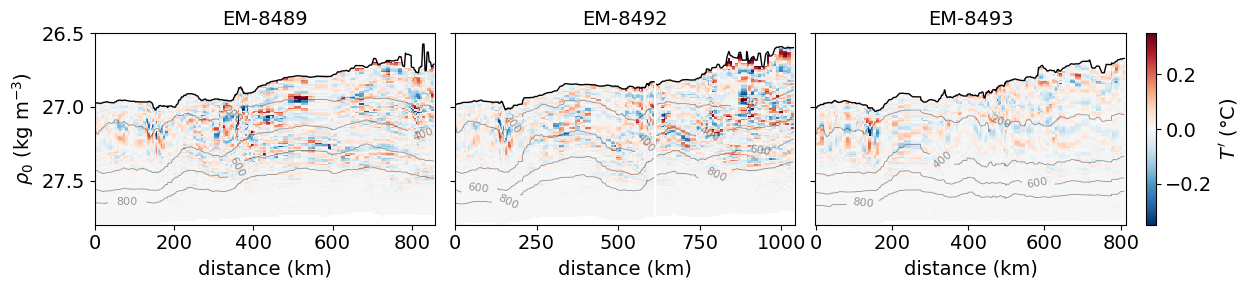

In [45]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3.1))
axs = ax.flatten()

imp.reload(interp)
i = 0
for floatid in floatids:
    Tanom_on_d = interp.to_pdens_grid(hf_ds[floatid].T_anom, dens[floatid], dens_interval = 0.01)
#     Tanom_even = interp.even_dist_grid(Tanom_on_d, 3)
#     p_on_d_even = interp.even_dist_grid(p_on_dens[floatid], 3)
#     mld_even = interp.even_dist_grid(mld_on_d[floatid], 3)

    
    im = Tanom_on_d.plot(ax = axs[i], x = 'distance', vmin = -0.35, vmax = 0.35, cmap = 'RdBu_r', add_colorbar = False)
    
    mld_on_d[floatid].plot(ax = axs[i], c = 'k', linewidth = 1)
    
    CS = p_on_dens[floatid].plot.contour(ax = axs[i],
                                        x = 'distance', 
                                        levels = np.arange(0, 1000, 200),
                                        linewidths = 0.6, 
                                        colors = 'k', 
                                        alpha = 0.4)
    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.0f')
    
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(26.5, 27.8)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel(r'$\rho_{0}$ (kg m$^{-3}$)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = u'$T^{\prime}$ (\N{DEGREE SIGN}C)')

# settings.save_figure(fig, my_path, 'Tanom_floats.png', dpi = 600, pad = 0.2)

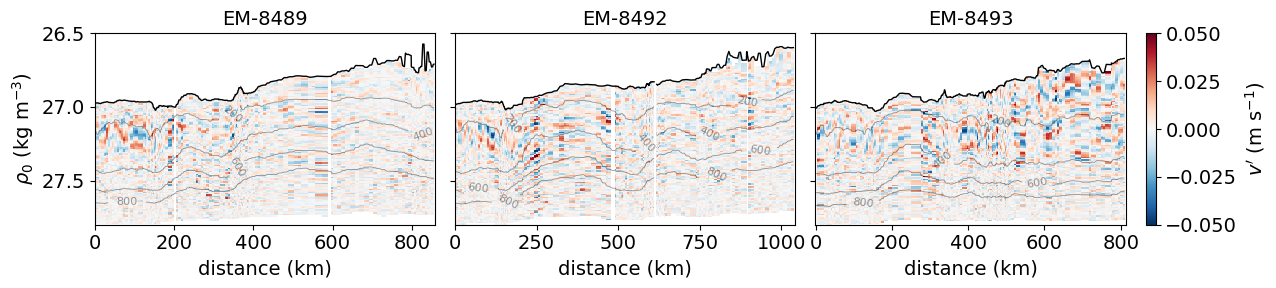

In [46]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3.1))
axs = ax.flatten()

imp.reload(interp)
i = 0
for floatid in floatids:
    vanom_on_d = interp.to_pdens_grid(hf_ds[floatid].v_anom, dens[floatid], dens_interval = 0.01)
    
    im = vanom_on_d.plot(ax = axs[i], x = 'distance', vmin = -0.05, vmax = 0.05,  cmap = 'RdBu_r', add_colorbar = False)
    
    mld_on_d[floatid].plot(ax = axs[i], c = 'k', linewidth = 1)
    
    CS = p_on_dens[floatid].plot.contour(ax = axs[i],
                                        x = 'distance', 
                                        levels = np.arange(0, 1000, 200),
                                        linewidths = 0.6, 
                                        colors = 'k', 
                                        alpha = 0.4)
    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.0f')
    
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(26.5, 27.8)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel(r'$\rho_{0}$ (kg m$^{-3}$)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = u'$v^{\prime}$ (m s$^{-1}$)')
